In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tkinter as tk

In [2]:
#Carregar dados
data_set = pd.read_excel('C:\\Users\\Bruno Ribeiro\\Desktop\\tese\\Bases de dados\\Sala 103\\Base_dados_103_clean.xlsx')
data_set.head()

,Outside temperature (x10)(ºC),Temperature 103 (x10)(ºC),Humidity 103 (x10)(%),Heat Index 103 (x10)(ºC),Occupation,AC status 103 (bool)
0,177,189,588,174.884999,0,0
1,177,189,587,174.881376,0,0
2,177,189,588,174.884999,0,0
3,177,189,587,174.881376,0,0
4,176,189,587,174.881376,0,0


In [3]:
print("Tamanho base de dados original:", len(data_set))

Tamanho base de dados original: 103949


In [4]:
#Oversampling 
X = data_set[['Outside temperature (x10)(ºC)', 'Temperature 103 (x10)(ºC)', 'Humidity 103 (x10)(%)', 'Heat Index 103 (x10)(ºC)', 'Occupation ']]
y = data_set['AC status 103 (bool)']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [5]:
#Tamanho base de dados após oversampling
print("Tamanho base de dados após oversampling:", len(X_resampled))

Tamanho base de dados após oversampling: 307437


In [6]:
#Divisão dados treino + teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.19, random_state=42)

In [7]:
#Definir os parâmetros para o Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#classificador RandomForest
rf_clf = RandomForestClassifier(random_state=42)

#Grid Search
grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)


In [8]:
#Treinar modelo 
grid_search.fit(X_train, y_train)
#melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor pontuação de validação cruzada:", grid_search.best_score_)

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhor pontuação de validação cruzada: 0.992241678777253


In [9]:
#Obter o melhor modelo
best_rf_clf = grid_search.best_estimator_
#Realizar previsões no conjunto de teste com o melhor modelo
y_pred = best_rf_clf.predict(X_test)

In [10]:
#acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy * 100:.5f}%')

Acurácia do modelo: 99.38885%


Matriz de Confusão:
[[19446   119     0]
 [  180 19205    43]
 [    0    15 19406]]


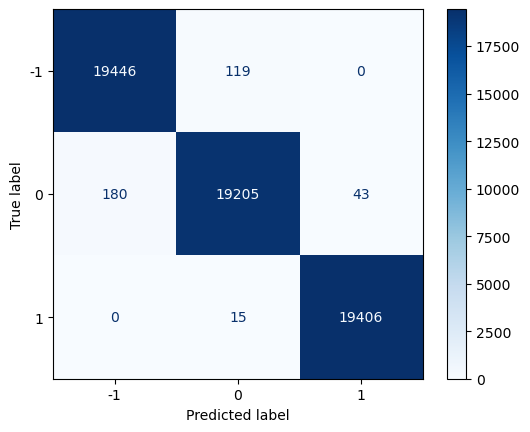

In [11]:
#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
 
import matplotlib.pyplot as plt
class_labels = ['-1', '0', '1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

#Precisão, Recall e F1-Score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precisão: {precision:.10f}')
print(f'Recall: {recall:.10f}')
print(f'F1-score: {f1:.10f}')

Precisão: 0.9938885316
Recall: 0.9938884514
F1-score: 0.9938857772


In [13]:
from sklearn.model_selection import cross_val_score


#validação cruzada (k-fold com k=5)
scores = cross_val_score(best_rf_clf, X_resampled, y_resampled, cv=5)
#média e o desvio padrão das pontuações da validação cruzada

print(f'Média das pontuações: {scores.mean():.10f}')
print(f'Desvio padrão das pontuações: {scores.std():.10f}')
print("Pontuações da validação cruzada:", scores)

Média das pontuações: 0.9094385868
Desvio padrão das pontuações: 0.0657718740
Pontuações da validação cruzada: [0.80119698 0.94688394 0.95499862 0.97736107 0.86675232]


In [14]:
#Previsões com base nos valores de entrada
def predict_ac_status():
    outside_temp = float(entry_outside_temp.get())
    temp_103 = float(entry_temp_103.get())
    humidity_103 = float(entry_humidity_103.get())
    heat_index_103 = float(entry_heat_index_103.get())
    occupation = float(entry_occupation.get())

    #Previsão com base nos valores inseridos
    prediction = best_rf_clf.predict([[outside_temp, temp_103, humidity_103, heat_index_103, occupation]])

    #Controlar o resultado para "Ligar AC em quente", "Ligar AC em frio" ou "desligar o AC"
    if prediction[0] == -1:
        result_label.config(text="Ligar AC em quente")
    elif prediction[0] == 1:
        result_label.config(text="Ligar AC em frio")
    else:
        result_label.config(text="Desligar o AC")

In [15]:
#Interface
root = tk.Tk()
root.title("Sistema de Controlo do AC")

frame = tk.Frame(root)
frame.pack(padx=20, pady=20)

#Entrada dados
entry_outside_temp = tk.Entry(frame, width=10, justify='center')
entry_temp_103 = tk.Entry(frame, width=10, justify='center')
entry_humidity_103 = tk.Entry(frame, width=10, justify='center')
entry_heat_index_103 = tk.Entry(frame, width=10, justify='center')
entry_occupation = tk.Entry(frame, width=10, justify='center')

entry_outside_temp.grid(row=0, column=1)
entry_temp_103.grid(row=1, column=1)
entry_humidity_103.grid(row=2, column=1)
entry_heat_index_103.grid(row=3, column=1)
entry_occupation.grid(row=4, column=1)

#Título das variáveis
tk.Label(frame, text="Outside Temperature (x10)(ºC)").grid(row=0, column=0)
tk.Label(frame, text="Temperature 103 (x10)(ºC)").grid(row=1, column=0)
tk.Label(frame, text="Humidity (x10)(%)").grid(row=2, column=0)
tk.Label(frame, text="Heat Index 103 (x10)(ºC)").grid(row=3, column=0)
tk.Label(frame, text="Occupation").grid(row=4, column=0)

#'Prever'
predict_button = tk.Button(frame, text="Prever", command=predict_ac_status)
predict_button.grid(row=5, columnspan=2)

#Resultado
result_label = tk.Label(frame, text="")
result_label.grid(row=6, columnspan=2)

root.mainloop()
